# Random Forest


In [ ]:
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone
from itertools import product
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [9]:
X_all = joblib.load("Data/Xtrain1.pkl")
Y_all = np.load('Data/Ytrain1.npy')
print(X_all.shape)
print(Y_all.shape)

patient_ids = X_all["Patient_Id"].values

mask_test = np.isin(patient_ids, [2, 3, 4])
mask_train = ~np.isin(patient_ids, [1, 2, 3, 4])

X_train_df = X_all[mask_train]
Y_train = Y_all[mask_train]

X_test_df = X_all[mask_test]
Y_test = Y_all[mask_test]

X_train = np.vstack(X_train_df["Skeleton_Features"].values)
X_test = np.vstack(X_test_df["Skeleton_Features"].values)


train_patient_ids = X_train_df["Patient_Id"].values

(700, 2)
(700,)


GridSearchCV progress: 100%|██████████| 24/24 [00:28<00:00,  1.19s/it]



Best CV macro-F1: 0.8208
Best parameters found: {'clf__n_estimators': 200, 'clf__max_depth': 10, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1}
Test macro-F1: 88.63%
              precision    recall  f1-score   support

         0.0      0.756     0.983     0.855        60
         1.0      0.976     0.683     0.804        60
         2.0      1.000     1.000     1.000        30

    accuracy                          0.867       150
   macro avg      0.911     0.889     0.886       150
weighted avg      0.893     0.867     0.864       150



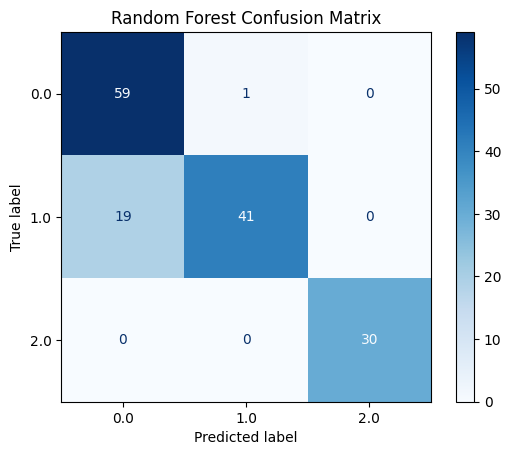

In [10]:
# --- Random Forest pipeline ---
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# --- Parameter grid ---
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

# Flatten param_grid
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

# --- GroupKFold CV ---
gkf = GroupKFold(n_splits=3)
splits = list(gkf.split(X_train, Y_train, groups=train_patient_ids))

# --- Manual Grid Search ---
best_score = 0
best_params = None

for params in tqdm(param_combinations, desc="GridSearchCV progress"):
    scores = []
    for train_idx, val_idx in splits:
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = Y_train[train_idx], Y_train[val_idx]

        model = clone(rf_pipe)
        model.set_params(**params)
        start = time.time()
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(f1_score(y_val, y_pred, average='macro'))

    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nBest CV macro-F1: {best_score:.4f}")
print("Best parameters found:", best_params)

# --- Train RF with best parameters ---
rf_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(
        n_estimators=best_params['clf__n_estimators'],
        max_depth=best_params['clf__max_depth'],
        min_samples_split=best_params['clf__min_samples_split'],
        min_samples_leaf=best_params['clf__min_samples_leaf'],
        class_weight='balanced',
        random_state=42
    ))
])

rf_pipe.fit(X_train, Y_train)

# --- Predict and evaluate on test set ---
y_pred = rf_pipe.predict(X_test)

test_f1 = f1_score(Y_test, y_pred, average='macro')
print(f"Test macro-F1: {test_f1*100:.2f}%")
print(classification_report(Y_test, y_pred, digits=3))

# --- Confusion matrix ---
classes = np.unique(Y_test)
cm = confusion_matrix(Y_test, y_pred, labels=classes)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", values_format="d")
plt.title("Random Forest Confusion Matrix")
plt.show()